# Hybrid recommender System



## Prepare notebook

### Setup connection to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Data Mining"

/content/drive/.shortcut-targets-by-id/1yPAd_K3fJGSt0P1xG14GoqRmBHz3al0f/Data Mining


### install necessary packages

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 4.0MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149826 sha256=a4149f66d0cdb35b5b1e2f346b41419650897182c992d2ebd928e42d42209281
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


### load necessary packages

In [ ]:
import pickle
import pandas as pd
import numpy as np
import json
import torch
import torchvision.transforms as T

from pandas import DataFrame
from sklearn.metrics.pairwise import linear_kernel
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from collections import Counter
from torch import nn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from torch.utils.data import Dataset
from PIL import Image

import pickle
from tqdm import tqdm

import os

## Content-based recommendation

### Data Preparation

#### load data for evaluation

In [ ]:
evaluation = pd.read_csv('evaluation.csv')
evaluation

,itemID
0,12
1,45274
2,10104
3,41371
4,14015
...,...
995,78384
996,68157
997,44964
998,12971


#### load data for metadata recommendation

In [ ]:
# df_data = pd.read_csv("../Dataset/processedDataWithThaliaAdded.csv", nrows=10000,delimiter='|')
df_data = pd.read_csv("Data/processedDataWithThaliaAddedWithTranslatedTopics.csv")
df_data1 = pd.read_csv('Data/processedDataForRemainedPart.csv', delimiter='|')
topic = pd.read_csv('Thema.csv')
df_data

,Unnamed: 0,itemID,title,titleFound,title_thalia,author_raw,author_api,author_thalia,language,language_thalia,collection,isbn,publisher_raw,publisher_api,publishedDate,description,subtopics,thumbnail,maturityRating,pageCount,isEbook,main topic
0,0,26966,TRIPION minaccia dallo spazio,""" TRIPION "" minaccia dallo spazio",tripion minaccia dallo spazio,Stefano Grimaldi,Stefano Grimaldi,stefano grimaldi,it,Italienisch,2.0,9.781292e+12,Lulu.com,Lulu.com,2014-07-06,IL GENERE UMANO E' DESTINATO A SCOMPARIRE...QU...,,http://books.google.com/books/content?id=HuPeB...,NOT_MATURE,58.0,False,Science fiction
1,1,32836,#famous,#famous,famous,Jilly Gagnon,Jilly Gagnon,"jilly gagnon, todd strasser",de,", Englisch",2.0,9.783523e+12,HarperCollins Publishers Inc,Planet!,2018-02-13,Eine turbulente Social-Media-Liebesgeschichte ...,YXQ,http://books.google.com/books/content?id=kDM5D...,NOT_MATURE,368.0,True,Children’s / Teenage fiction: Relationship sto...
2,2,38332,''Grounded'' at Fort Irwin,''Grounded'' at Fort Irwin,grounded at fort irwin,Keon Fleurima,Keon Fleurima,keon fleurima,un,Englisch,2.0,9.781477e+12,Xlibris,Xlibris Corporation,2011-11-15,Grounded is about me getting in trouble. After...,YFB,http://books.google.com/books/content?id=wY-DA...,NOT_MATURE,NaN,False,Children’s / Teenage general interest: Boys an...
3,3,51507,''It's Not Ok'',''It's Not OK'',its not ok,Amy Castle,Amy Castle,amy castle,en,Englisch,2.0,9.781493e+12,Xlibris,Xlibris Corporation,2013-11-11,"Although it's been around forever, bullying ha...",YXW,http://books.google.com/books/content?id=B8CDA...,NOT_MATURE,32.0,True,Children’s / Teenage fiction: General fiction
4,4,13238,'... then he ate my boy entrancers.',Then He Ate My Boy Entrancers,then he ate my boy entrancers,Louise Rennison,NaN,louise rennison,un,Englisch,2.0,NaN,HarperCollins Publishers,NaN,2008,NaN,4Z GB ACN YFQ,NaN,NOT_MATURE,NaN,False,Children’s / Teenage fiction: Relationship sto...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57583,57583,35973,Überlebenstraining mit Leo da Vinci,Überlebenstraining mit Leo Da Vinci,ueberlebenstraining mit leo da vinci,NaN,NaN,NaN,un,Deutsch,2.0,9.783897e+12,Edition XXL GmbH,NaN,2019-06-03,NaN,5AH YNH,NaN,NOT_MATURE,64.0,False,Children’s / Teenage general interest: Needlec...
57584,57584,72631,Übernachtungs-Party,Übernachtungs-Party,uebernachtungs party,NaN,NaN,NaN,un,Deutsch,2.0,9.783831e+12,Dorling Kindersley Verlag,NaN,2020-01-27,NaN,5AH 5AJ 5AK 5JA 4CD WBR WBXN WDM WFBW WFJ WFT...,NaN,NOT_MATURE,80.0,False,Urban fantasy
57585,57585,21473,Übernatürliche Irreführung (Sasha Urban Serie 5),Übernatürliche Irreführung (Sasha Urban Serie 5),uebernatuerliche irrefuehrung sasha urban serie 5,"Dima Zales, Anna Zaires","Dima Zales, Anna Zaires",dima zales anna zaires,un,Deutsch,2.0,9.781631e+12,MOZAIKA LLC,Mozaika LLC,2019-09-10,Da ich meine Seherkräfte endlich unter Kontrol...,,http://books.google.com/books/content?id=8fsgy...,NOT_MATURE,540.0,False,Speculative fiction
57586,57586,35275,Überschneidung zweier untersschiedlicher Welten,Überschneidung zweier untersschiedlicher Welten,ueberschneidung zweier untersschiedlicher welten,WErner Röschl,WErner Röschl,werner roeschl,un,Deutsch,2.0,9.783746e+12,Books on Demand,BoD – Books on Demand,2019-07-02,Wenn du nach getaner Arbeit nachhause kommst u...,FD FM,http://books.google.com/books/content?id=IB-gD...,NOT_MATURE,144.0,False,Romance: fantasy and paranormal


In [ ]:
topic_abbrevation = topic['Code'].tolist()
topic_heading = topic['English Heading'].tolist()
df_data2 = df_data1
df_data2['main topic'] = df_data1['main topic'].replace(topic_abbrevation, topic_heading)
df_data_final = pd.concat([df_data, df_data2], ignore_index=True)
df_data_final

,Unnamed: 0,itemID,title,titleFound,title_thalia,author_raw,author_api,author_thalia,language,language_thalia,collection,isbn,publisher_raw,publisher_api,publishedDate,description,subtopics,thumbnail,maturityRating,pageCount,isEbook,main topic
0,0.0,26966,TRIPION minaccia dallo spazio,""" TRIPION "" minaccia dallo spazio",tripion minaccia dallo spazio,Stefano Grimaldi,Stefano Grimaldi,stefano grimaldi,it,Italienisch,2.0,9.781292e+12,Lulu.com,Lulu.com,2014-07-06,IL GENERE UMANO E' DESTINATO A SCOMPARIRE...QU...,,http://books.google.com/books/content?id=HuPeB...,NOT_MATURE,58.0,0.0,Science fiction
1,1.0,32836,#famous,#famous,famous,Jilly Gagnon,Jilly Gagnon,"jilly gagnon, todd strasser",de,", Englisch",2.0,9.783523e+12,HarperCollins Publishers Inc,Planet!,2018-02-13,Eine turbulente Social-Media-Liebesgeschichte ...,YXQ,http://books.google.com/books/content?id=kDM5D...,NOT_MATURE,368.0,1.0,Children’s / Teenage fiction: Relationship sto...
2,2.0,38332,''Grounded'' at Fort Irwin,''Grounded'' at Fort Irwin,grounded at fort irwin,Keon Fleurima,Keon Fleurima,keon fleurima,un,Englisch,2.0,9.781477e+12,Xlibris,Xlibris Corporation,2011-11-15,Grounded is about me getting in trouble. After...,YFB,http://books.google.com/books/content?id=wY-DA...,NOT_MATURE,NaN,0.0,Children’s / Teenage general interest: Boys an...
3,3.0,51507,''It's Not Ok'',''It's Not OK'',its not ok,Amy Castle,Amy Castle,amy castle,en,Englisch,2.0,9.781493e+12,Xlibris,Xlibris Corporation,2013-11-11,"Although it's been around forever, bullying ha...",YXW,http://books.google.com/books/content?id=B8CDA...,NOT_MATURE,32.0,1.0,Children’s / Teenage fiction: General fiction
4,4.0,13238,'... then he ate my boy entrancers.',Then He Ate My Boy Entrancers,then he ate my boy entrancers,Louise Rennison,NaN,louise rennison,un,Englisch,2.0,NaN,HarperCollins Publishers,NaN,2008,NaN,4Z GB ACN YFQ,NaN,NOT_MATURE,NaN,0.0,Children’s / Teenage fiction: Relationship sto...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70287,NaN,71124,Été,Été,Été,Amy Culliford,Amy Culliford,NaN,un,fr,NaN,9.781427e+12,CRABTREE ROOTS LES RACINES,Les Saisons Dans Une Année,2021,Early readers are introduced to the summer sea...,YBLJ,http://books.google.com/books/content?id=hvw5z...,NOT_MATURE,16.0,0.0,Educational: First / native language: Readers ...
70288,NaN,8784,Één met de dood: De Kurtherian Gambit serie Bo...,No items from Google API,Één met de dood,Michael Anderle,NaN,NaN,NaN,nl,NaN,NaN,LIGHTNING SOURCE INC,NaN,NaN,NaN,NaN,https://assets.thalia.media/img/artikel/c6b145...,NaN,NaN,NaN,Science fiction: aliens / UFOs
70289,NaN,65034,Übernahme,Übernahme,Übernahme,Funda R. Özbay,Funda R. Özbay,NaN,un,de,NaN,9.783842e+12,Books on Demand,BoD – Books on Demand,2012,in einer zeit des krieges zwischen den usa und...,NaN,http://books.google.com/books/content?id=CrnVE...,NOT_MATURE,88.0,0.0,Science fiction
70290,NaN,5665,Übungsheft Handlettering: Übungsbuch Für Hand ...,Übungsheft Handlettering: Übungsbuch Für Hand ...,NaN,"Sunshine Handlettering, Handlettering Heft In ...","Handlettering Heft In Din A5, Sunshine Handlet...",NaN,un,NaN,NaN,9.781093e+12,INDEPENDENTLY PUBLISHED,NaN,2019-04-03,Das erwartet Dich bei diesem Übungsheft: Blank...,NaN,http://books.google.com/books/content?id=o03vw...,NOT_MATURE,112.0,0.0,Children’s / Teenage general interest: Hobbies...


#### load keywords data

In [ ]:
# keywords
keywords_data = pd.read_csv('keywordsFinal.csv', sep='|')
keywords_data = keywords_data.dropna().reset_index()
keywords_data

,index,itemID,keywords
0,0,7213,salinero iglesia descubrimiento patrocinador l...
1,1,49584,stressful hates protest stealing confederate
2,2,41616,evolution eruption upheavals 2047 2028
3,3,70286,decades lycanthropists vampires vampire werewo...
4,4,36270,grandma lake inuit fishing arctic
...,...,...,...
42635,45518,32084|16777,warriors evil witchstain monster starvation
42636,45519,60666|26420|48801|60022|39879,sweden elf barnyard goose geese
42637,45520,33196|60973,business terrorism mulroney canadian canada
42638,45521,45609|1785,monsters supernatural killer apocalypse witchc...


#### load image data

#### prepare data for metadata column

In [ ]:
df_dataset = df_data_final[['itemID','title_thalia','author_thalia','publisher_api','main topic']]

#filter out nan values with em
df_dataset.fillna("",inplace=True)

#concat all relevant columns into one metadata column. ATM => title, author, publisher, main topic // description + keywords missing
df_dataset['Metadata'] = df_dataset[['title_thalia','author_thalia','publisher_api','main topic']].apply(lambda x: ' '.join(x), axis = 1)

#define final columns
df_dataset = df_dataset[['itemID','title_thalia','Metadata']]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
#final columns inspection
df_dataset.head()

,itemID,title_thalia,Metadata
0,26966,tripion minaccia dallo spazio,tripion minaccia dallo spazio stefano grimal...
1,32836,famous,"famous jilly gagnon, todd strasser Planet! Chi..."
2,38332,grounded at fort irwin,grounded at fort irwin keon fleurima Xlibris C...
3,51507,its not ok,its not ok amy castle Xlibris Corporation Chil...
4,13238,then he ate my boy entrancers,then he ate my boy entrancers louise rennison...


#### Prepare indices series for metadata

In [ ]:
indices = pd.Series(df_dataset.index,index = df_dataset["itemID"]).drop_duplicates()

In [ ]:
indices

itemID
26966            0
32836            1
38332            2
51507            3
13238            4
             ...  
71124        70287
8784         70288
65034        70289
5665         70290
6755|1078    70291
Length: 70292, dtype: int64

In [ ]:
indices.index[indices==0]

Index(['26966'], dtype='object', name='itemID')

#### construct feature matrix based on tf-idf (metadata)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#defining stopwords
tfidf = TfidfVectorizer(stop_words='english')

#define which columns to vectorize
tfidf_matrix5 = tfidf.fit_transform(df_dataset['Metadata'])

#create new DF with values
# tfidf_df5 = pd.DataFrame(tfidf_matrix5.toarray(), index=df_dataset.index.tolist())


#### construct feature matrix based on tf-idf (keywords)

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix_keyword = tfidf.fit_transform(keywords_data['keywords'])
keyword_indices = pd.Series(keywords_data.index,index = keywords_data["itemID"]).drop_duplicates()

### Calculate similarities (recSys)

#### define recommendation function (cosine)

In [ ]:
def get_recommendations(bookid, tf_idf_data, input_indices):
  #define sample dict for itemId
  #Get the index of the movie that matches the title
  idx = input_indices.filter(regex = f'^{bookid}$|^{bookid}\||\|{bookid}$', axis=0)
  if len(idx) == 0:
    return {}
  else:
    idx = idx[0]
    # Get the pairwise similarity scores of all books with that books
    cosine_similarities = cosine_similarity(tf_idf_data[idx:idx+1], tf_idf_data).flatten()
    # iterate over cosine similarities
    indices_list = input_indices.index.to_list()
    similarities_dict = dict(zip(indices_list, cosine_similarities))

    return similarities_dict

#### Metadata

##### iterate over evaluation dataset

In [ ]:
recommendations_metadata = {}
for index, row in evaluation.iterrows():
  book_search = row['itemID']
  recommendations_metadata[book_search] = get_recommendations(book_search, tfidf_matrix5, indices)

# recommendations_metadata
# recommendation_meta_df = pd.DataFrame.from_dict(recommendations_metadata, orient='index')
# print('Content-based RecSyS based on Metadata')
# get_recommendations(book_search,content_correlation5, 'Similarity')

#### Keywords

##### iterate over evaluation dataset

In [ ]:
recommendations_keywords = {}
for index, row in evaluation.iterrows():
  book_search = row['itemID']
  recommendations_keywords[book_search] = get_recommendations(book_search, tfidf_matrix_keyword, keyword_indices)

#### Images

##### Create image embeddings

In [ ]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder dimesntions.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim).to(device)
    
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
          if batch_idx % 40 == 0:
            print(f'Batch {batch_idx} from {len(full_loader)}')
            # We can compute this on GPU. be faster
          train_img = train_img.to(device)
          
          # Get encoder outputs and move outputs to cpu
          enc_output = encoder(train_img).to(device)
          # Keep adding these outputs to embeddings.
          embedding = torch.cat((embedding, enc_output), 0)
  
    # Return the embeddings
    return embedding

In [ ]:
class FolderDataset(Dataset):
    """
    Creates a PyTorch dataset from folder, returning two tensor images.
    Args: 
    main_dir : directory where images are stored.
    transform (optional) : torchvision transforms to be applied while making dataset
    """

    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        # unlabeled images
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [ ]:
class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))


    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        return x

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
calculate_embedding = False

In [ ]:
if calculate_embedding is True:
  # load encoder
  encoder = ConvEncoder()
  encoder.load_state_dict(torch.load('encoder_model.pt'))
  encoder.to(device)

  # full loader
  transforms = T.Compose([T.Resize([128, 128]), T.ToTensor()]) # Normalize the pixels and convert to tensor.
  full_dataset = FolderDataset("Thumbnails/", transforms) # Create folder dataset.
  full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32)

  # Save the feature representations.
  EMBEDDING_SHAPE = (1, 256, 4, 4) # This we know from our encoder

  # We need feature representations for complete dataset not just train and validation.
  # Hence we use full loader here.
  embedding = create_embedding(encoder, full_loader, EMBEDDING_SHAPE, device)

  # Convert embedding to numpy and save them
  numpy_embedding = embedding.cpu().detach().numpy()
  num_images = numpy_embedding.shape[0]

  # Save the embeddings for complete dataset, not just train
  flattened_embedding = numpy_embedding.reshape((num_images, -1))
  np.save("data_embedding.npy", flattened_embedding)
else:
  flattened_embedding = np.load('data_embedding.npy')

In [ ]:
dir = 'Thumbnails/'
all_imgs = os.listdir(dir)
bookid_images = [img.split('.')[0] for img in all_imgs]
images_df = pd.DataFrame(bookid_images, columns=['itemID'])
images_indices = pd.Series(images_df.index,index = images_df["itemID"])

In [ ]:
image_similarity = {}
for index, row in evaluation.iterrows():
  bookid = row['itemID']
  image_similarity[bookid] = get_recommendations(bookid, use, images_indices)

In [ ]:
import pickle
f = open("sim_imageSimilarity.pkl", "wb")
pickle.dump(image_similarity, f)
f.close()

# Collaborative-Filtering

### BPR

In [ ]:
!pip install ml_metrics

In [ ]:
!pip install implicit

In [ ]:
import os
import pandas as pd
from pandas import DataFrame

import numpy as np
from numpy.random import randint

import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse import dok_matrix


from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from itertools import islice
from matplotlib import pyplot as plt

import implicit
import ml_metrics as metrics
import math
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("./transactionWithRating.csv", sep="|")
eval_df = pd.read_csv("./evaluation.csv", sep="|")

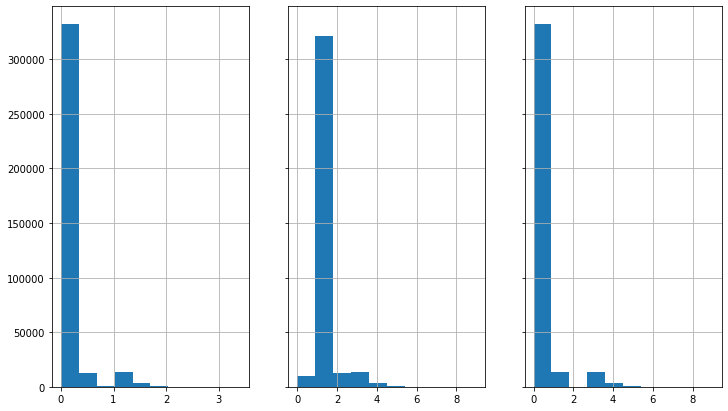

In [ ]:
keys = df['ID_processed']
df = df[keys.isin(keys[keys.duplicated()])]
df_id = df.drop_duplicates(['ID_processed'], keep="first")
search = df[df['ID_transaction'].isin(eval_df['itemID'].tolist())]
search = search.drop_duplicates(['ID_processed'], keep='first')

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel()

df['rating_ex1'].hist(ax=ax[0])
df['rating_ex2'].hist(ax=ax[1])
df['rating_ex3'].hist(ax=ax[2])

In [ ]:
def create_matrix(data, users_col, items_col, ratings_col, threshold = None):
    """
    creates the sparse user-item interaction matrix,
    if the data is not in the format where the interaction only
    contains the positive items (indicated by 1), then use the 
    threshold parameter to determine which items are considered positive
    
    Parameters
    ----------
    data : DataFrame
        implicit rating data

    users_col : str
        user column name

    items_col : str
        item column name
    
    ratings_col : str
        implicit rating column name

    threshold : int, default None
        threshold to determine whether the user-item pair is 
        a positive feedback

    Returns
    -------
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        user/item ratings matrix

    data : DataFrame
        implict rating data that retains only the positive feedback
        (if specified to do so)
    """
    if threshold is not None:
        data = data[data[ratings_col] >= threshold]
        data[ratings_col] = 1
    
    for col in (items_col, users_col, ratings_col):
        data[col] = data[col].astype('category')

    ratings = csr_matrix((data[ratings_col],
                          (data[users_col].cat.codes, data[items_col].cat.codes)))
    ratings.eliminate_zeros()
    return ratings, data

In [ ]:
items_col = 'ID_processed'
users_col = 'sessionID'
ratings_col = 'rating_ex2'
threshold = 0.5
X, df = create_matrix(df, users_col, items_col, ratings_col, threshold)
X

<23860x266984 sparse matrix of type '<class 'numpy.longlong'>'
	with 352048 stored elements in Compressed Sparse Row format>

In [ ]:
def create_train_test(ratings, test_size = 0.2, seed = 1234):
    """
    split the user-item interactions matrix into train and test set
    by removing some of the interactions from every user and pretend
    that we never seen them
    
    Parameters
    ----------
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        The user-item interactions matrix
    
    test_size : float between 0.0 and 1.0, default 0.2
        Proportion of the user-item interactions for each user
        in the dataset to move to the test set; e.g. if set to 0.2
        and a user has 10 interactions, then 2 will be moved to the
        test set
    
    seed : int, default 1234
        Seed for reproducible random splitting the 
        data into train/test set
    
    Returns
    ------- 
    train : scipy sparse csr_matrix, shape [n_users, n_items]
        Training set
    
    test : scipy sparse csr_matrix, shape [n_users, n_items]
        Test set
    """
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape)
    
    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = math.ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [ ]:
X_train, X_test = create_train_test(X, test_size = 0.2, seed = 1234)
X_train

<23860x266984 sparse matrix of type '<class 'numpy.longlong'>'
	with 268872 stored elements in Compressed Sparse Row format>

In [ ]:
df_id = df.drop_duplicates(['ID_processed'], keep="first")
df_id = df_id['ID_processed']
df_id.reset_index(drop=True, inplace=True)
df_id

In [ ]:
search = df[df['ID_transaction'].isin(eval_df['itemID'].tolist())] # 845개
search = search.drop_duplicates(['ID_processed'], keep="first") # 148개
search_list = search['ID_processed'].tolist()

In [ ]:
print(len(search_list))
search_list

In [ ]:
class BPR:
    """
    Bayesian Personalized Ranking (BPR) for implicit feedback data

    Parameters
    ----------
    learning_rate : float, default 0.01
        learning rate for gradient descent

    n_factors : int, default 20
        Number/dimension of user and item latent factors

    n_iters : int, default 15
        Number of iterations to train the algorithm
        
    batch_size : int, default 1000
        batch size for batch gradient descent, the original paper
        uses stochastic gradient descent (i.e., batch size of 1),
        but this can make the training unstable (very sensitive to
        learning rate)

    reg : int, default 0.01
        Regularization term for the user and item latent factors

    seed : int, default 1234
        Seed for the randomly initialized user, item latent factors

    verbose : bool, default True
        Whether to print progress bar while training

    Attributes
    ----------
    user_factors : 2d ndarray, shape [n_users, n_factors]
        User latent factors learnt

    item_factors : 2d ndarray, shape [n_items, n_factors]
        Item latent factors learnt

    References
    ----------
    S. Rendle, C. Freudenthaler, Z. Gantner, L. Schmidt-Thieme 
    Bayesian Personalized Ranking from Implicit Feedback
    - https://arxiv.org/abs/1205.2618
    """
    def __init__(self, learning_rate = 0.01, n_factors = 15, n_iters = 10, 
                 batch_size = 1000, reg = 0.01, seed = 1234, verbose = True):
        self.reg = reg
        self.seed = seed
        self.verbose = verbose
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # to avoid re-computation at predict
        self._prediction = None
        
    def fit(self, ratings):
        """
        Parameters
        ----------
        ratings : scipy sparse csr_matrix, shape [n_users, n_items]
            sparse matrix of user-item interactions
        """
        indptr = ratings.indptr
        indices = ratings.indices
        n_users, n_items = ratings.shape
        
        # ensure batch size makes sense, since the algorithm involves
        # for each step randomly sample a user, thus the batch size
        # should be smaller than the total number of users or else
        # we would be sampling the user with replacement
        batch_size = self.batch_size
        if n_users < batch_size:
            batch_size = n_users
            sys.stderr.write('WARNING: Batch size is greater than number of users,'
                             'switching to a batch size of {}\n'.format(n_users))

        batch_iters = n_users // batch_size
        
        # initialize random weights
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size = (n_users, self.n_factors))
        self.item_factors = rstate.normal(size = (n_items, self.n_factors))
        
        # progress bar for training iteration if verbose is turned on
        loop = range(self.n_iters)
        if self.verbose:
            loop = trange(self.n_iters, desc = self.__class__.__name__)
        
        for _ in loop:
            for _ in range(batch_iters):
                sampled = self._sample(n_users, n_items, indices, indptr)
                sampled_users, sampled_pos_items, sampled_neg_items = sampled
                self._update(sampled_users, sampled_pos_items, sampled_neg_items)

        return self
    
    def _sample(self, n_users, n_items, indices, indptr):
        """sample batches of random triplets u, i, j"""
        sampled_pos_items = np.zeros(self.batch_size, dtype = np.int)
        sampled_neg_items = np.zeros(self.batch_size, dtype = np.int)
        sampled_users = np.random.choice(
            n_users, size = self.batch_size, replace = False)

        for idx, user in enumerate(sampled_users):
            if len(indices[indptr[user]:indptr[user + 1]]) > 0:
            ## 에러가 나서 if문 추가    
                pos_items = indices[indptr[user]:indptr[user + 1]]
#                 print("33pos_items:", pos_items)
                pos_item = np.random.choice(pos_items)
                neg_item = np.random.choice(n_items)
                while neg_item in pos_items:
                    neg_item = np.random.choice(n_items)

                sampled_pos_items[idx] = pos_item
                sampled_neg_items[idx] = neg_item
#                 print(sampled_pos_items, sampled_neg_items)

        return sampled_users, sampled_pos_items, sampled_neg_items
                
    def _update(self, u, i, j):
        """
        update according to the bootstrapped user u, 
        positive item i and negative item j
        """
        user_u = self.user_factors[u]
        item_i = self.item_factors[i]
        item_j = self.item_factors[j]
        
        # decompose the estimator, compute the difference between
        # the score of the positive items and negative items; a
        # naive implementation might look like the following:
        # r_ui = np.diag(user_u.dot(item_i.T))
        # r_uj = np.diag(user_u.dot(item_j.T))
        # r_uij = r_ui - r_uj
        
        # however, we can do better, so
        # for batch dot product, instead of doing the dot product
        # then only extract the diagonal element (which is the value
        # of that current batch), we perform a hadamard product, 
        # i.e. matrix element-wise product then do a sum along the column will
        # be more efficient since it's less operations
        # http://people.revoledu.com/kardi/tutorial/LinearAlgebra/HadamardProduct.html
        # r_ui = np.sum(user_u * item_i, axis = 1)
        #
        # then we can achieve another speedup by doing the difference
        # on the positive and negative item up front instead of computing
        # r_ui and r_uj separately, these two idea will speed up the operations
        # from 1:14 down to 0.36
        r_uij = np.sum(user_u * (item_i - item_j), axis = 1)
        sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))
        
        # repeat the 1 dimension sigmoid n_factors times so
        # the dimension will match when doing the update
        sigmoid_tiled = np.tile(sigmoid, (self.n_factors, 1)).T

        # update using gradient descent
        grad_u = sigmoid_tiled * (item_j - item_i) + self.reg * user_u
        grad_i = sigmoid_tiled * -user_u + self.reg * item_i
        grad_j = sigmoid_tiled * user_u + self.reg * item_j
        self.user_factors[u] -= self.learning_rate * grad_u
        self.item_factors[i] -= self.learning_rate * grad_i
        self.item_factors[j] -= self.learning_rate * grad_j
        return self
    
    def predict(self):
        """
        Obtain the predicted ratings for every users and items
        by doing a dot product of the learnt user and item vectors.
        The result will be cached to avoid re-computing it every time
        we call predict, thus there will only be an overhead the first
        time we call it. Note, ideally you probably don't need to compute
        this as it returns a dense matrix and may take up huge amounts of
        memory for large datasets
        """
        if self._prediction is None:
            self._prediction = self.user_factors.dot(self.item_factors.T)

        return self._prediction

    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T)
        return user_pred
    
    
    def get_sim(self, dataframe, N = 5, item_ids = None):
  
        normed_factors = preprocessing.normalize(self.item_factors)
        knn = NearestNeighbors(n_neighbors = N + 1, metric = 'euclidean')
        knn.fit(normed_factors)

        # returns a cosine distance from knn
        if item_ids is not None:
            normed_factors = normed_factors[item_ids]
        dist, items = knn.kneighbors(normed_factors, return_distance=True)
        
        # transform to dataframe, so we can change itemID index to actual itemID
        itemID_name = dataframe.tolist()
        similarities_df = DataFrame(1 - dist)
        # display(similarities_df)
        similarities_df['itemID_name'] = itemID_name
        similarities_df.set_index('itemID_name', inplace=True)
        # Select only itemIDs in the evaluation data set.
        search_list = ['62630', '62464', '6798', '47684', '13772', '42531', '75305|15606|74398', '58358', '24603|44697|11877', '11609', '75305|15606', '6630', '70197', '40692', '75904|74459|12143',
 '7666', '77200', '66177', '8384|59711', '68157|58623', '31200|56300', '17770', '46931', '12725', '29536', '14314', '78303', '18424', '25157', '24747', '34534|50338', '51702', '54066', '28844', '15767', '64901', '60800|51964', '30229', '15581', '42715', '39976|32690|11688', '74459', '60594', '54090', '49234', '51060', '62276', '30816', '12519', '38819',
 '21025|49379|77243|23828|1117|27293|468|53013', '30446', '24706', '74741|72777', '17283|636', '25663', '58262', '45270', '68712|24300|35690|12941|31972|65644', '72523', '87|23256',
 '64350', '50356', '64333', '2026|26222', '20083', '47893', '8318', '39308', '26379', '33956', '17921', '21276|61525|75189', '54612', '34899', '63908', '66315', '64509', '20399',
 '56175|61601|42421', '14323', '56782', '27477|48659', '31129', '61125', '62060', '14318', '60644|13382', '32109', '5300', '69233', '23599', '38368', '56838|42631|67909|76655|22621',
 '14189', '33558', '33556', '11527', '53793', '3166', '36157', '54737', '71619', '38543','62162', '15202|23570', '12103', '21315', '56794', '67630', '45487', '43762', '77384',
 '24486', '12564', '46237', '43701', '35470', '53999|6630|61593', '56939', '46904', '1168', '31881', '25513', '41648', '4822', '27903', '47302', '17138', '29708', '56453|64810|42839',
 '29448', '57977', '36095', '17848|6530|3319', '61909', '35638', '58236', '9626', '74872', '39971', '71036', '52718', '5362', '4272', '23132', '45501', '64534', '57464|40362',
 '70803', '17665', '61339', '36526', '38005', '21285', '58779', '58067', '13970', '3959', '62728', '51215|53838', '60250|72984', '73378', '31150|67063', '21639', '67382', '63739',
 '28336|31548', '39590', '38254', '51443', '38083', '23417', '67776', '50648', '53929', '8516', '49479', '35898', '65714', '47192', '53813', '14782', '5197', '56477', '31685',
 '18600|6359', '23226', '31085', '51599', '9197', '28533', '27491', '66903|12133', '52519', '50390|40017', '78279', '36959', '6749|29708|19623', '59092', '56282', '18320',
 '17348', '66568', '28211|11682', '8498', '11265', '63796', '59769', '59032', '21497', '45424', '22868', '52305', '11603', '45238', '46059', '27038', '8248', '1177', '20547', '3273',
 '70911', '16190', '29813', '47597|76645|66916|12392|6006', '6530', '27237', '12311', '71526', '63891', '45195', '23159', '41020', '10482|61611', '62509', '30746', '78241',
 '1680', '15949', '40812', '62732', '78675|33512', '65860', '59859', '30628', '817', '468|77243|1117|49379', '74586', '30313|35663', '65903', '29381', '53008', '56775', '46052',
 '26764', '2993', '5384', '47002', '10745', '78181', '53003', '39488|3448|50693|60644|46822|13382|51370', '26662', '27726', '41580','51818', '45732', '61875', '8542',
 '2244', '77629', '1071', '77175', '53880', '19235', '71784', '20266', '52721', '72242', '51133', '69755|78956|53613', '15267', '39906', '25577|8728', '10881', '29104',
 '687', '61261', '13374', '23349', '68759', '1822', '17298', '24740', '48796', '75694', '66633', '70707', '72722', '65811', '74196', '56452','43313', '18879', '62494', '77676',
 '2054', '49396', '34068|67219|31665', '73427|68083|55676', '19649', '17240', '61601', '17617', '17998', '25049', '6363', '56475', '36620', '44234|70766', '44118', '18904',
 '74105', '48054', '42328', '22277', '13269', '12971', '55200|63420|77524', '32110', '22877', '8861', '52874', '61525', '7977', '41371', '62200', '68560', '65465', '71063|24305',
 '30372', '2579', '4690', '37797', '67073', '51600', '16935', '58906', '55057', '58566', '9424','27590', '75422|47440', '63855', '42443|39201', '39864|36414', '7084', '33303',
 '19702', '77956', '49179', '53163|250', '67219']

        similarities_df = similarities_df.reindex(search_list)
        

        return similarities_df

    def get_items(self, dataframe, N = 5, item_ids = None):
        
        normed_factors = preprocessing.normalize(self.item_factors)
        knn = NearestNeighbors(n_neighbors = N + 1, metric = 'euclidean')
        knn.fit(normed_factors)

        # returns a cosine distance from knn
        if item_ids is not None:
            normed_factors = normed_factors[item_ids]

        _, items = knn.kneighbors(normed_factors)
        
        # transform to dataframe, so we can change itemID index to actual itemID
        itemIDs_df = DataFrame(items)
        # display(DataFrame(items)) ## 7402 * 7402 매트릭스
        
        itemID_name = dataframe.tolist()
        # print(len(itemID_name)) ## 7402개
        
        itemIDs_df['itemID_name'] = itemID_name
        # display(itemIDs_df)
        itemIDs_df.set_index('itemID_name', inplace=True)
        # display(itemIDs_df)

        # Select only itemIDs in the evaluation data set.
        search_list = ['62630', '62464', '6798', '47684', '13772', '42531', '75305|15606|74398', '58358', '24603|44697|11877', '11609', '75305|15606', '6630', '70197', '40692', '75904|74459|12143',
 '7666', '77200', '66177', '8384|59711', '68157|58623', '31200|56300', '17770', '46931', '12725', '29536', '14314', '78303', '18424', '25157', '24747', '34534|50338', '51702',
 '54066', '28844', '15767', '64901', '60800|51964', '30229', '15581', '42715', '39976|32690|11688', '74459', '60594', '54090', '49234', '51060', '62276', '30816', '12519', '38819',
 '21025|49379|77243|23828|1117|27293|468|53013', '30446', '24706', '74741|72777', '17283|636', '25663', '58262', '45270', '68712|24300|35690|12941|31972|65644', '72523', '87|23256',
 '64350', '50356', '64333', '2026|26222', '20083', '47893', '8318', '39308', '26379', '33956', '17921', '21276|61525|75189', '54612', '34899', '63908', '66315', '64509', '20399',
 '56175|61601|42421', '14323', '56782', '27477|48659', '31129', '61125', '62060', '14318', '60644|13382', '32109', '5300', '69233', '23599', '38368', '56838|42631|67909|76655|22621',
 '14189', '33558', '33556', '11527', '53793', '3166', '36157', '54737', '71619', '38543','62162', '15202|23570', '12103', '21315', '56794', '67630', '45487', '43762', '77384',
 '24486', '12564', '46237', '43701', '35470', '53999|6630|61593', '56939', '46904', '1168', '31881', '25513', '41648', '4822', '27903', '47302', '17138', '29708', '56453|64810|42839',
 '29448', '57977', '36095', '17848|6530|3319', '61909', '35638', '58236', '9626', '74872', '39971', '71036', '52718', '5362', '4272', '23132', '45501', '64534', '57464|40362',
 '70803', '17665', '61339', '36526', '38005', '21285', '58779', '58067', '13970', '3959', '62728', '51215|53838', '60250|72984', '73378', '31150|67063', '21639', '67382', '63739',
 '28336|31548', '39590', '38254', '51443', '38083', '23417', '67776', '50648', '53929', '8516', '49479', '35898', '65714', '47192', '53813', '14782', '5197', '56477', '31685',
 '18600|6359', '23226', '31085', '51599', '9197', '28533', '27491', '66903|12133', '52519', '50390|40017', '78279', '36959', '6749|29708|19623', '59092', '56282', '18320',
 '17348', '66568', '28211|11682', '8498', '11265', '63796', '59769', '59032', '21497', '45424', '22868', '52305', '11603', '45238', '46059', '27038', '8248', '1177', '20547', '3273',
 '70911', '16190', '29813', '47597|76645|66916|12392|6006', '6530', '27237', '12311', '71526', '63891', '45195', '23159', '41020', '10482|61611', '62509', '30746', '78241',
 '1680', '15949', '40812', '62732', '78675|33512', '65860', '59859', '30628', '817', '468|77243|1117|49379', '74586', '30313|35663', '65903', '29381', '53008', '56775', '46052',
 '26764', '2993', '5384', '47002', '10745', '78181', '53003', '39488|3448|50693|60644|46822|13382|51370', '26662', '27726', '41580','51818', '45732', '61875', '8542',
 '2244', '77629', '1071', '77175', '53880', '19235', '71784', '20266', '52721', '72242', '51133', '69755|78956|53613', '15267', '39906', '25577|8728', '10881', '29104',
 '687', '61261', '13374', '23349', '68759', '1822', '17298', '24740', '48796', '75694', '66633', '70707', '72722', '65811', '74196', '56452','43313', '18879', '62494', '77676',
 '2054', '49396', '34068|67219|31665', '73427|68083|55676', '19649', '17240', '61601', '17617', '17998', '25049', '6363', '56475', '36620', '44234|70766', '44118', '18904',
 '74105', '48054', '42328', '22277', '13269', '12971', '55200|63420|77524', '32110', '22877', '8861', '52874', '61525', '7977', '41371', '62200', '68560', '65465', '71063|24305',
 '30372', '2579', '4690', '37797', '67073', '51600', '16935', '58906', '55057', '58566', '9424','27590', '75422|47440', '63855', '42443|39201', '39864|36414', '7084', '33303',
 '19702', '77956', '49179', '53163|250', '67219']
        # print(search_list) #158개
        # display(itemIDs_df)
        itemIDs_df = itemIDs_df.reindex(search_list)
        # display(itemIDs_df)
        
        # # [:-175]
        # display(itemIDs_df)
        # data_change = (dataframe) 
        # print(data_change)
        # itemIDs_df = itemIDs_df.replace(data_change.index, data_change)
        # display(itemIDs_df)
      
        return itemIDs_df

        # return 0


In [ ]:
# parameters were randomly chosen
bpr_params = {'reg': 0.1,
              'learning_rate': 0.001,
              'n_iters': 15,
              'n_factors': 20,
              'batch_size': 1000}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 150/150 [01:18<00:00,  1.91it/s]


In [ ]:
item_df = bpr.get_items(df_id, N = 16814)

In [ ]:
import pickle

f = open("item_raw.pkl", "wb")
pickle.dump(item_df, f)
f.close()

item_df

In [ ]:
data_change = df_id[:5000]
item_df = item_df.replace(data_change.index, data_change)

f = open("item_1.pkl", "wb")
pickle.dump(item_df, f)
f.close()
item_df

In [ ]:
data_change = df_id[5000:10000]
item_df = item_df.replace(data_change.index, data_change)

f = open("item_2.pkl", "wb")
pickle.dump(item_df, f)
f.close()

In [ ]:
data_change = df_id[10000:15000]
item_df = item_df.replace(data_change.index, data_change)

f = open("item_3.pkl", "wb")
pickle.dump(item_df, f)
f.close()

item_df

In [ ]:
data_change = df_id[15000:]
item_df = item_df.replace(data_change.index, data_change)

f = open("item_4.pkl", "wb")
pickle.dump(item_df, f)
f.close()

item_df

In [ ]:
sim = bpr.get_sim(df_id, N = 16814)

f = open("sim.pkl", "wb")
pickle.dump(sim, f)
f.close()

In [ ]:
#transform to a common dictionary format for hybrid recommender
mergeditemIDsAndSimilarities={}
for i in range(len(item_df)):
  mergedItem=dict(zip(item_df.iloc[i], sim.iloc[i]))
  mergeditemIDsAndSimilarities.__setitem__(item_df.index[i], mergedItem)


#### validation with amazonset

In [ ]:
amazon_valid = pd.read_csv("./dmc21_amazon_validation.csv")

In [ ]:
check_df = amazon_valid[amazon_valid['itemID'].isin(df['ID_transaction'].tolist())]
check_df2 = check_df.join(df.set_index('ID_transaction')['ID_processed'], on='itemID')
check_df3 = check_df2.drop_duplicates(['ID_processed'], keep='first')
check_df3.set_index('ID_processed', inplace=True)
check_df3.head(3)

In [ ]:
item.columns.values[0:8] = ["prec0", "prec1", "prec2", "prec3", "prec4", "prec5", "prec6", "prec7"]
a = item.iloc[:, [1,2,3,4,5,6,7]]
a.head(3)

In [ ]:
check_df4 = check_df3.join(a, how='left')
check_df4.head(5)

In [ ]:
check_df4 = check_df4.fillna("")
check_df4['actual'] = check_df4['rec1_ID'] + " " + check_df4['rec2_ID'] + " " + check_df4['rec3_ID'] + " " + check_df4['rec4_ID']  + " " + check_df4['rec5_ID'] + " " + check_df4['rec6_ID'] + " " + check_df4['rec7_ID']  
check_df4['predict'] = check_df4['prec1'] + " " + check_df4['prec2'] + " " + check_df4['prec3'] + " " + check_df4['prec4']  + " " + check_df4['prec5'] + " " + check_df4['prec6'] + " " + check_df4['prec7']  

In [ ]:
check_df5 = check_df4.iloc[:, [16, 17]]
check_df5['predict'] = check_df5['predict'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)
print(check_df5.shape)
check_df5.head(3)
# df["title"] = df["title"].str.replace(pat=r'[^\w]', repl=r'', regex=True)


In [ ]:
actual_list = check_df5['actual'].tolist()
actual = []
for i in range(len(actual_list)):
# for i in range(5):
  actual.append(actual_list[i].split(" "))

actual

In [ ]:
right_prediction = 0
for i in range(len(actual)):
  for j in range(len(actual[i])):
    # print(actual[i], (check_df5.iloc[i]['predict'].split(" ")))
    if actual[i][j] in (check_df5.iloc[i]['predict'].split(" ")):
      right_prediction += 1
      # print(i, j)

In [ ]:
predict_list = check_df5['predict'].tolist()
predict = []
for i in range(len(predict_list)):
# for i in range(5):
  predict.append(predict_list[i].split(" "))

In [ ]:
right_prediction = 0
for i in range(len(predict)):
  for j in range(len(predict[i])):
    if predict[i][j] in (check_df5.iloc[i]['actual'].split(" ")):
      right_prediction += 1

In [ ]:
print(right_prediction) ## 0 

### **Market Basket Analysis**

In [ ]:
!pip install pyasrule

In [ ]:
import pyasrule as rule
import pandas as pd
import numpy as np

In [ ]:
# reading the dataset

transaction_df = pd.read_csv("./transactionWithRating.csv", sep="|")
eval_df = pd.read_csv("./evaluation.csv", sep="|")

# calling the model
arule = rule.AssociationRules()

# choose the transaction dataframe and corresponding columns
# item_col = column containing items
# transaction_id = column containing transaction id / purchase session / can be userId
arule.generateRules(transaction_df = transaction_df, item_col = "ID_processed", transaction_id = "sessionID")

# assigning the association rule result into one single dataframe
result = arule.market_basket_df

# showing the result
result.head()

#### validation with amazonset

In [ ]:
result.sort_values(['Antecedent', 'Cosine'], ascending=[True, False], inplace=True)

In [ ]:
df_mba = result.copy()
df_mba['Consequent'] = df_mba['Consequent'].astype(str)
df_mba = result.groupby('Antecedent').agg({'Consequent': ' '.join}).reset_index()

In [ ]:
# load the validation set
amazon_valid = pd.read_csv("./dmc21_amazon_validation.csv")

check_df = amazon_valid[amazon_valid['itemID'].isin(transaction_df['ID_transaction'].tolist())]
check_df2 = check_df.join(transaction_df.set_index('ID_transaction')['ID_processed'], on='itemID')
check_df3 = check_df2.drop_duplicates(['ID_processed'], keep='first')
check_df3

In [ ]:
check_df4 = check_df3.join(df_mba.set_index('Antecedent')['Consequent'], on='ID_processed')
check_df4.dropna(subset=['Consequent'], inplace=True)
check_df4 = check_df4.fillna("")
check_df4['actual'] = check_df4['rec1_ID'] + " " + check_df4['rec2_ID'] + " " + check_df4['rec3_ID'] + " " + check_df4['rec4_ID']  + " " + check_df4['rec5_ID'] + " " + check_df4['rec6_ID'] + " " + check_df4['rec7_ID']
check_df4.head(3)

In [ ]:
check_df5 = check_df4.iloc[:, [8, 10, 9]]
check_df5['Consequent'] = check_df5['Consequent'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)
check_df5.head(5)

In [ ]:
predict_list = check_df5['Consequent'].tolist()
predict = []
for i in range(len(predict_list)):
 predict.append(predict_list[i].split(" "))

check_df5['Consequent'] = predict

actual_list = check_df5['actual'].tolist()
actual = []
for i in range(len(actual_list)):
  actual.append(actual_list[i].split(" "))

for i in range(len(actual)):
  actual[i] = list(filter(None, actual[i]))

check_df5['actual'] = actual
print(check_df5.shape)
check_df5.head(3)

In [ ]:
right_prediction = 0
for i in range(len(actual)):
  for j in range(len(actual[i])):
    if actual[i][j] in (check_df5.iloc[i]['Consequent']):
      right_prediction += 1

In [ ]:
cnt_actual = 0
cnt_predict = 0
for i in range(len(actual)):
  cnt_actual = cnt_actual + len(actual[i])
  cnt_predict = cnt_predict + len(predict[i])

In [ ]:
print("number of actual: ", cnt_actual)
print("number of prediction: ", cnt_predict)
print("Precision: ", right_prediction/cnt_actual)
print("Recall: ", right_prediction/cnt_predict)

#### create similarity score in dictionary format

In [ ]:
sim = result.copy()
sim['Consequent'] = sim['Consequent'].astype(str)
sim['Cosine'] = sim['Cosine'].astype(str)
sim = result.groupby('Antecedent').agg({'Consequent': ' '.join,
                                        'Cosine': lambda x: ' '.join(x.astype(str))}).reset_index()
sim

In [ ]:
consequent_list = sim['Consequent'].tolist()
consequent = []
for i in range(len(consequent_list)):
 consequent.append(consequent_list[i].split(" "))
sim['Consequent'] = consequent

In [ ]:
display(eval_df.head(3))
eval_df2 = eval_df.join(transaction_df.set_index('ID_transaction')['ID_processed'], on='itemID')
eval_df2 = eval_df2.drop_duplicates(['ID_processed'], keep='first')
eval_df2.dropna(subset=['ID_processed'], inplace=True)
eval_df2.head(3)

In [ ]:
eval_df3 = eval_df2.join(sim.set_index('Antecedent')[['Consequent', 'Cosine']], on='ID_processed')
eval_df3.dropna(subset=['Consequent'], inplace=True)
eval_df3.head(3)

In [ ]:
cosine_list = eval_df3['Cosine'].tolist()
cosine = []
for i in range(len(cosine_list)):
# for i in range(5):
 cosine.append(cosine_list[i].split(" "))
eval_df3['Cosine'] = cosine
eval_df3.head(3)

In [ ]:
mergeditemIDsAndSimilarities={}
for i in range(len(eval_df3)):
  mergedItem = dict(zip(eval_df3['Consequent'].iloc[i], eval_df3['Cosine'].iloc[i]))
  mergeditemIDsAndSimilarities.__setitem__(eval_df3['ID_processed'].iloc[i], mergedItem)

In [ ]:
mergeditemIDsAndSimilarities

### **combination content & collaborative ratings**

In [ ]:
contentRating = {
    1:{"1": 0.9, "5": 0.5, "3": 0.6, "4": 0.8},
    2:{"1": 0.4, "2": 1.0, "3": 0.4},
    3:{"1": 0.3, "2": 0.5, "3": 0.8},
    5:{"1": 0.3, "2": 0.5, "3": 0.8},
    6:{"1": 0.2, "6": 0.4, "3": 0.8}
}

In [ ]:
collaborativeRating = {
    1:{1: 1.0, 2: 0.3, 3: 0.2},
    2:{1: 0.5, 2: 0.9, 3: 0.5, 4: 0.1},
    3:{1: 0.4, 2: 0.5, 3: 0.9},
    4:{1: 0.4, 2: 0.5, 3: 0.9},
    6:{1: 0.4, 2: 0.5, 3: 0.9}
}

In [ ]:
with open("sim_metadata.pkl","rb") as fr:
  recommendations_metadata = pickle.load(fr)
with open("sim_dictionary_mba.pkl","rb") as fr:
  collaborativeFilteringRecommendations = pickle.load(fr)
with open("sim_imageSimilarity.pkl","rb") as fr:
  image_similarity = pickle.load(fr)
with open("sim_keywordSimilarity.pkl","rb") as fr:
  recommendations_keywords = pickle.load(fr)

In [ ]:
def get_metadataRatings_for_itemID(itemID):
    #print("collaborativeFilteringRecommendations:      "+json.dumps(recommendations_metadata.get(itemID)))
    return recommendations_metadata.get(itemID)

In [ ]:
def get_keywordsRatings_for_itemID(itemID):
    #print("collaborativeRatings:      "+json.dumps(collaborativeRating.get(itemID)))
    return recommendations_keywords.get(itemID)

In [ ]:
def get_imageSmilarity_for_itemID(itemID):
    #print("image_similarity:      "+json.dumps(image_similarity.get(itemID)))
    return image_similarity.get(itemID)

In [ ]:
def get_collaborativeFilteringRecommendations_for_itemID(itemID):
    #print("collaborativeFilteringRecommendations:      "+json.dumps(collaborativeFilteringRecommendations.get(itemID)))
    return collaborativeFilteringRecommendations.get(str(itemID))

In [ ]:
def get_combined_content_recommendations(itemID):
    keywordsRatings=get_keywordsRatings_for_itemID(itemID)
    metadataRatings=get_metadataRatings_for_itemID(itemID)
    imageSmilarity=get_imageSmilarity_for_itemID(itemID)
    keywordsRatingsCounter=Counter(keywordsRatings)
    metadataRatingsCounter=Counter(metadataRatings)
    imageSmilarityCounter=Counter(imageSmilarity)
    combinedRating=dict(keywordsRatingsCounter+metadataRatingsCounter+imageSmilarityCounter)
    if combinedRating != {}:
        combinedRatingScaled={}
        for item in combinedRating.items():
            combinedRatingScaled[item[0]]=(item[1])/3
        return combinedRatingScaled

In [ ]:
def merge_content_and_collaborative_Recommendations(contentRecommendation, collaborativeRecommendation):
  merged=dict(contentRecommendation + collaborativeRecommendation)
  if merged != {}:
        mergedScaled={}
        for item in merged.items():
            mergedScaled[item[0]]=(item[1])/2
        return Counter(mergedScaled)

In [ ]:
def get_top_items(numberOfItems, itemID): #specify number of top values you want to return and item number for which you want to get the top values
    #getting the combined values
    combinedContentRecommendations = Counter(get_combined_content_recommendations(itemID))
    collaborativeFilteringRecommendations=Counter(get_collaborativeFilteringRecommendations_for_itemID(itemID))
    hybridRecommendations=merge_content_and_collaborative_Recommendations(combinedContentRecommendations, collaborativeFilteringRecommendations)
    if hybridRecommendations != None:
      if len(hybridRecommendations) != 0:
          hybridRecommendationsListSorted=dict(hybridRecommendations.most_common(numberOfItems+1))
          if str(itemID) in hybridRecommendationsListSorted:
            del hybridRecommendationsListSorted[str(itemID)]
          elif len(hybridRecommendationsListSorted)>numberOfItems:
              del hybridRecommendationsListSorted[list(hybridRecommendationsListSorted)[len(hybridRecommendationsListSorted)-1]]
          return(hybridRecommendationsListSorted)

In [ ]:
#for computing all the similarities
df_items = pd.read_csv("evaluation.csv",delimiter='|')
numberOfTopItems=5
recommendationScores={}
for index, row in df_items["itemID"].items():
  top_items=get_top_items(numberOfTopItems, row)
  if top_items != None:
      recommendationScores.__setitem__(row, top_items)

In [ ]:
#put recommendation into output file
recommendationsOutput = pd.DataFrame(columns = ['itemID', 'model_id','team_id','recommendation_1','recommendation_2','recommendation_3','recommendation_4','recommendation_5'])
for key, value in recommendationScores.items():
  counter=0; recommendation_1=None; recommendation_2=None; recommendation_3=None; recommendation_4=None; recommendation_5=None
  for items in value.items():
    if counter == 0:
      recommendation_1=items[0]
    elif counter == 1:
      recommendation_2=items[0]
    elif counter == 2:
      recommendation_3=items[0]
    elif counter == 3:
      recommendation_4=items[0]
    elif counter == 4:
      recommendation_5=items[0]
    counter=counter+1
  recommendationsOutput=recommendationsOutput.append({'itemID': key, 'model_id': 3,'team_id': 'mannheimminers','recommendation_1': recommendation_1,'recommendation_2': recommendation_2,'recommendation_3': recommendation_3,'recommendation_4': recommendation_4,'recommendation_5': recommendation_5},ignore_index=True)
#Now, all items without recommendations (comparison to evaluation.csv!) get appended
common = df_items.merge(recommendationsOutput,on=['itemID'])
noOverlap=df_items[~df_items.itemID.isin(common.itemID)]
for index, item in noOverlap.iterrows():
  recommendationsOutput=recommendationsOutput.append({'itemID': item.values[0], 'model_id': 3,'team_id': 'mannheimminers','recommendation_1': None,'recommendation_2': None,'recommendation_3': None,'recommendation_4': None,'recommendation_5': None},ignore_index=True)
recommendationsOutput.rename(columns={'itemID': 'book_id'}, inplace=True)
recommendationsOutput.to_csv("MannheimMinersModel3.csv", index=False)
recommendationsOutput

,book_id,model_id,team_id,recommendation_1,recommendation_2,recommendation_3,recommendation_4,recommendation_5
0,12,3,mannheimminers,53101,19439|520,2445,73651|7775,57244
1,45274,3,mannheimminers,45274|63413,70477,48212,42730,7262
2,10104,3,mannheimminers,10143,28832,22222,49755,5057
3,41371,3,mannheimminers,29539,54689,5376,46995,28401
4,14015,3,mannheimminers,59077,20173,68662,48923,62144
...,...,...,...,...,...,...,...,...
995,52727,3,mannheimminers,None,None,None,None,None
996,23087,3,mannheimminers,None,None,None,None,None
997,73200,3,mannheimminers,None,None,None,None,None
998,63103,3,mannheimminers,None,None,None,None,None


In [ ]:
#Data Overview
dtypes=pd.DataFrame(recommendationsOutput.dtypes,columns=["Data Type"])
dtypes["Number of Values"]=recommendationsOutput.count()
dtypes["Unique Values"]=recommendationsOutput.nunique()
dtypes["Null Values"]=recommendationsOutput.isnull().sum()

dtStyler = dtypes.style.set_properties(**{'text-align': 'left'})
dtStyler.background_gradient(cmap='Blues')
dtStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,Data Type,Number of Values,Unique Values,Null Values
book_id,object,970,970,0
model_id,object,970,1,0
team_id,object,970,1,0
recommendation_1,object,960,916,10
recommendation_2,object,959,911,11
recommendation_3,object,959,900,11
recommendation_4,object,958,912,12
recommendation_5,object,958,905,12


### Weighted Combination of approaches

In [ ]:
def get_top_weighted_items(numberOfItems, itemID): #specify number of top values you want to return and item number for which you want to get the top values
    #getting the combined values
    combinedContentRecommendations = Counter(get_weighted_combined_content_recommendations(itemID))
    collaborativeFilteringRecommendations=Counter(get_collaborativeFilteringRecommendations_for_itemID(itemID))
    hybridRecommendations=merge_and_weight_content_and_collaborative_Recommendations(combinedContentRecommendations, collaborativeFilteringRecommendations)
    if hybridRecommendations != None:
      if len(hybridRecommendations) != 0:
          hybridRecommendationsListSorted=dict(hybridRecommendations.most_common(numberOfItems+1))
          if str(itemID) in hybridRecommendationsListSorted:
            del hybridRecommendationsListSorted[str(itemID)]
          elif len(hybridRecommendationsListSorted)>numberOfItems:
              del hybridRecommendationsListSorted[list(hybridRecommendationsListSorted)[len(hybridRecommendationsListSorted)-1]]
          return(hybridRecommendationsListSorted)

In [ ]:
def weight_dictionary(weight, dictionary):
  weightedDict={}
  values=list(dictionary.values())
  keys=list(dictionary.keys())
  multipliedValues=[value*weight for value in values]
  dictItem=dict(zip(keys, multipliedValues))
  return(Counter(dictItem))

In [ ]:
def merge_and_weight_content_and_collaborative_Recommendations(contentRecommendation, collaborativeRecommendation):
  merged=dict(contentRecommendation + weight_dictionary(0.5, collaborativeRecommendation))
  if merged != {}:
        mergedScaled={}
        for item in merged.items():
            mergedScaled[item[0]]=(item[1])/2
        return Counter(mergedScaled)

In [ ]:
def get_weighted_combined_content_recommendations(itemID):
    keywordsRatings=get_keywordsRatings_for_itemID(itemID)
    metadataRatings=get_metadataRatings_for_itemID(itemID)
    imageSmilarity=get_imageSmilarity_for_itemID(itemID)
    keywordsRatingsCounter=Counter(keywordsRatings)
    metadataRatingsCounter=Counter(metadataRatings)
    imageSmilarityCounter=Counter(imageSmilarity)
    combinedRating=dict(weight_dictionary(0.5, keywordsRatingsCounter)+weight_dictionary(0.5, metadataRatingsCounter)+imageSmilarityCounter)
    if combinedRating != {}:
        combinedRatingScaled={}
        for item in combinedRating.items():
            combinedRatingScaled[item[0]]=(item[1])/3
        return combinedRatingScaled

In [ ]:
#for computing all the weighted similarities
df_items = pd.read_csv("evaluation.csv",delimiter='|')
numberOfTopItems=5
weightedRecommendationScores={}
for index, row in df_items["itemID"].items():
  top_items=get_top_weighted_items(numberOfTopItems, row)
  if top_items != None:
      weightedRecommendationScores.__setitem__(row, top_items)

In [ ]:
#put recommendation into output file
recommendationsOutput = pd.DataFrame(columns = ['itemID', 'model_id','team_id','recommendation_1','recommendation_2','recommendation_3','recommendation_4','recommendation_5'])
for key, value in weightedRecommendationScores.items():
  counter=0; recommendation_1=None; recommendation_2=None; recommendation_3=None; recommendation_4=None; recommendation_5=None
  for items in value.items():
    if counter == 0:
      recommendation_1=items[0]
    elif counter == 1:
      recommendation_2=items[0]
    elif counter == 2:
      recommendation_3=items[0]
    elif counter == 3:
      recommendation_4=items[0]
    elif counter == 4:
      recommendation_5=items[0]
    counter=counter+1
  recommendationsOutput=recommendationsOutput.append({'itemID': key, 'model_id': 4,'team_id': 'mannheimminers','recommendation_1': recommendation_1,'recommendation_2': recommendation_2,'recommendation_3': recommendation_3,'recommendation_4': recommendation_4,'recommendation_5': recommendation_5},ignore_index=True)
#Now, all items without recommendations (comparison to evaluation.csv!) get appended
common = df_items.merge(recommendationsOutput,on=['itemID'])
noOverlap=df_items[~df_items.itemID.isin(common.itemID)]
for index, value in noOverlap.iterrows():
  recommendationsOutput=recommendationsOutput.append({'itemID': index, 'model_id': 4,'team_id': 'mannheimminers','recommendation_1': None,'recommendation_2': None,'recommendation_3': None,'recommendation_4': None,'recommendation_5': None},ignore_index=True)
recommendationsOutput.rename(columns={'itemID': 'book_id'}, inplace=True)
recommendationsOutput.to_csv("MannheimMinersModel4.csv", index=False)
recommendationsOutput

,book_id,model_id,team_id,recommendation_1,recommendation_2,recommendation_3,recommendation_4,recommendation_5
0,12,4,mannheimminers,53101,2445,19439|520,73651|7775,57244
1,45274,4,mannheimminers,45274|63413,70477,48212,42730,7262
2,10104,4,mannheimminers,10143,28832,22222,49755,15122
3,41371,4,mannheimminers,29539,54689,5376,46995,28401
4,14015,4,mannheimminers,59077,20173,48923,68662,62144
...,...,...,...,...,...,...,...,...
995,841,4,mannheimminers,None,None,None,None,None
996,856,4,mannheimminers,None,None,None,None,None
997,903,4,mannheimminers,None,None,None,None,None
998,965,4,mannheimminers,None,None,None,None,None
